In [1]:
from numba import cuda
import numpy as np
import matplotlib.pyplot as plt
import time

In [19]:
def print_image(image):
  fig, ax = plt.subplots()
  ax.imshow(image)
  ax.axis('off')
  plt.show()

In [31]:
gaussian_matrix = np.array([
    [0, 0, 1, 2, 1, 0, 0],
    [0, 3, 13, 22, 13, 3, 0],
    [1, 13, 59, 97, 59, 13, 1],
    [2, 22, 97, 159, 97, 22, 2],
    [1, 13, 59, 97, 59, 13, 1],
    [0, 3, 13, 22, 13, 3, 0],
    [0, 0, 1, 2, 1, 0, 0]
], dtype=np.float32)
gaussian_matrix /= 1003

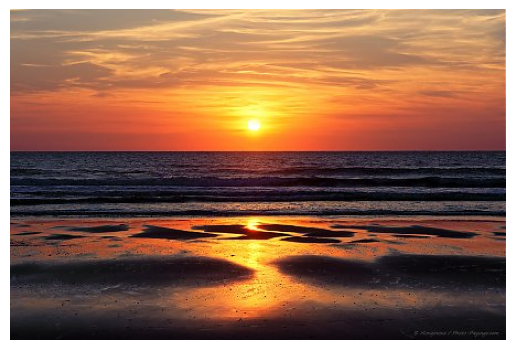

In [32]:
img=plt.imread('photoblur.jpg')
print_image(img)

In [27]:
import numpy as np
import time

def gaussian_blur_cpu(img, filter_size=7):
  blur_img = np.zeros(img.shape, np.uint8)
  height, width, _ = img.shape

  # get filter first
  hfs = filter_size // 2 #half filter size

  start_t = time.time()

  for row_id in range(height):
    for col_id in range(width):
      cell = [0]*3
      for i in range(filter_size):
        for j in range(filter_size):
          if i+row_id-hfs >= height or i+row_id-hfs < 0 or j+col_id-hfs >= width or j+col_id-hfs < 0:
            continue
          for channel in range(3):
            cell[channel] += gaussian_matrix[i][j] * img[i+row_id-hfs][j+col_id-hfs][channel]
      blur_img[row_id][col_id] = [int(cell[0]), int(cell[1]), int(cell[2])]

  total_time = time.time() - start_t
  print(f"CPU BLUR TIME {total_time} seconds")

  return blur_img, total_time

cpu_blur_img, _ = gaussian_blur_cpu(img)

CPU BLUR TIME 31.531569480895996 seconds


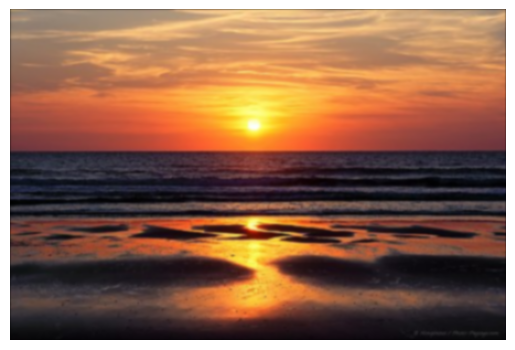

In [28]:
print_image(cpu_blur_img)

In [29]:
@cuda.jit
def gaussian_blur(src, dst, filter, xSize, ySize):
  tidx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
  tidy = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y

  filter_size = len(filter)
  hfs = filter_size // 2 #half filter size

  r, g, b = 0, 0, 0
  for i in range(filter_size):
    for j in range(filter_size):
      if i+tidx-hfs >= xSize or i+tidx-hfs < 0 or \
          j+tidy-hfs >= ySize or j+tidy-hfs < 0:
        continue
      r += filter[i][j] * src[i+tidx-hfs][j+tidy-hfs][0]
      g += filter[i][j] * src[i+tidx-hfs][j+tidy-hfs][1]
      b += filter[i][j] * src[i+tidx-hfs][j+tidy-hfs][2]

  dst[tidx, tidy, 0] = np.uint8(r)
  dst[tidx, tidy, 1] = np.uint8(g)
  dst[tidx, tidy, 2] = np.uint8(b)

def gaussian_blur_gpu_2d(img, blockSize=(32, 32)):
  imageHeight, imageWidth, _ = img.shape
  gridSize = ((imageHeight + blockSize[0] - 1) // blockSize[0],(imageWidth + blockSize[1] - 1) // blockSize[1])

  start_t = time.time()

  devSrc = cuda.to_device(img)
  devDst = cuda.device_array((imageHeight, imageWidth, 3), np.uint8)
  filter_gpu = cuda.to_device(gaussian_matrix)
  gaussian_blur[gridSize, blockSize](devSrc, devDst, filter_gpu, imageHeight, imageWidth)
  img = devDst.copy_to_host()

  gpu_time = time.time() - start_t
  print(f"GPU Time : {gpu_time:.5f} secondes")

  return img, gpu_time


GPU Time : 0.35993 secondes


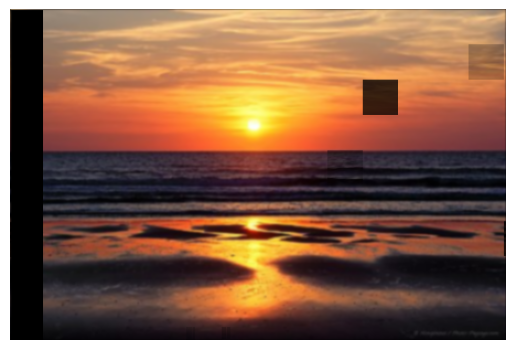

In [30]:
gpu_blur_img, _ = gaussian_blur_gpu_2d(img)

print_image(gpu_blur_img)